<a href="https://colab.research.google.com/github/kdemertzis/LNexamples/blob/main/Reservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import numpy as np

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CTRC model
class CTRC(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_reservoir, spectral_radius=0.9, connectivity=0.5, dt=0.01):
        super(CTRC, self).__init__()
        
        # Set the number of inputs and outputs
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # Set the time-step size
        self.dt = dt
        
        # Initialize the input-to-reservoir weight matrix
        self.input_weight = nn.Linear(n_inputs, n_reservoir, bias=False)
        torch.nn.init.normal_(self.input_weight.weight, mean=0, std=1)
        
        # Initialize the reservoir
        self.reservoir = nn.Linear(n_reservoir, n_reservoir, bias=False)
        torch.nn.init.normal_(self.reservoir.weight, mean=0, std=1)
        
        # Scale the reservoir connectivity
        self.reservoir.weight.data *= (torch.rand(n_reservoir, n_reservoir) < connectivity).float()
        
        # Set the spectral radius of the reservoir
        rho = torch.max(torch.abs(torch.linalg.eig(self.reservoir.weight)[0]))
        self.reservoir.weight.data *= spectral_radius / rho
        
        # Initialize the readout layer
        self.readout = nn.Linear(n_reservoir, n_outputs)
        
    def forward(self, input):
        # Initialize the reservoir state
        reservoir_state = torch.zeros(self.reservoir.weight.size(0)).to(device)
        
        # Iterate over the input sequence
        for i in range(input.size(0)):
            # Compute the reservoir state update
            input_proj = self.input_weight(input[i])
            reservoir_state = -self.dt * reservoir_state + torch.tanh(self.reservoir(reservoir_state) + input_proj)
        
        # Compute the readout layer output
        output = self.readout(reservoir_state)
        
        return output

# Define the training function
def train(model, dataloader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            # Move the data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Update the running loss
            running_loss += loss.item()
            
        # Print the loss for this epoch
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(dataloader)))
        
# Define the main function
if __name__ == 'main':
# Set the random seed
  np.random.seed(0)
  torch.manual_seed(0)

# Generate the input and output data
n_samples = 500
t = np.linspace(0, 10, n_samples)
x = np.sin(2 * np.pi * t)
y = np.cos(4 * np.pi * t)

# Reshape the input and output data
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Combine the input and output data
data = np.concatenate((x, y), axis=1)

# Split the data into training and testing sets
train_size = int(0.8 * n_samples)
train_data = data[:train_size, :]
test_data = data[train_size:, :]

# Create the training and testing datasets
train_dataset = TensorDataset(torch.Tensor(train_data[:-1, :]), torch.Tensor(train_data[1:, :]))
test_dataset = TensorDataset(torch.Tensor(test_data[:-1, :]), torch.Tensor(test_data[1:, :]))

# Define the model hyperparameters
n_inputs = 2
n_outputs = 2
n_reservoir = 100
spectral_radius = 0.9
connectivity = 0.5
dt = 0.01

# Create the CTRC model
model = CTRC(n_inputs, n_outputs, n_reservoir, spectral_radius, connectivity, dt).to(device)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create the training and testing data loaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Train the model
train(model, train_dataloader, loss_fn, optimizer, num_epochs=50)

# Test the model
test_loss = 0.0
for inputs, labels in test_dataloader:
    # Move the data to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute the loss
    test_loss += loss_fn(outputs, labels).item()

# Print the test loss
print('Test Loss: %.4f' % (test_loss/len(test_dataloader)))



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 1.0685
Epoch [2/50], Loss: 0.6215
Epoch [3/50], Loss: 0.5901
Epoch [4/50], Loss: 0.6151
Epoch [5/50], Loss: 0.5942
Epoch [6/50], Loss: 0.5541
Epoch [7/50], Loss: 0.5888
Epoch [8/50], Loss: 0.5521
Epoch [9/50], Loss: 0.5496
Epoch [10/50], Loss: 0.5873
Epoch [11/50], Loss: 0.7058
Epoch [12/50], Loss: 0.6947
Epoch [13/50], Loss: 0.6245
Epoch [14/50], Loss: 0.6247
Epoch [15/50], Loss: 0.6291
Epoch [16/50], Loss: 0.6069
Epoch [17/50], Loss: 0.5736
Epoch [18/50], Loss: 0.5602
Epoch [19/50], Loss: 0.5682
Epoch [20/50], Loss: 0.6451
Epoch [21/50], Loss: 0.6273
Epoch [22/50], Loss: 0.6066
Epoch [23/50], Loss: 0.6532
Epoch [24/50], Loss: 0.5677
Epoch [25/50], Loss: 0.7184
Epoch [26/50], Loss: 0.5523
Epoch [27/50], Loss: 0.6184
Epoch [28/50], Loss: 0.5684
Epoch [29/50], Loss: 0.5777
Epoch [30/50], Loss: 0.7031
Epoch [31/50], Loss: 0.5819
Epoch [32/50], Loss: 0.5844
Epoch [33/50], Loss: 0.6575
Epoch [34/50], Loss: 0.7403
Epoch [35/50], Loss: 0.6902
Epoch [36/50], Loss: 0.6891
E

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 1.0345
Epoch [2/50], Loss: 0.6263
Epoch [3/50], Loss: 0.6673
Epoch [4/50], Loss: 0.5703
Epoch [5/50], Loss: 0.5584
Epoch [6/50], Loss: 0.5259
Epoch [7/50], Loss: 0.5270
Epoch [8/50], Loss: 0.5073
Epoch [9/50], Loss: 0.5977
Epoch [10/50], Loss: 0.5121
Epoch [11/50], Loss: 0.5467
Epoch [12/50], Loss: 0.6434
Epoch [13/50], Loss: 0.5713
Epoch [14/50], Loss: 0.7284
Epoch [15/50], Loss: 0.6976
Epoch [16/50], Loss: 0.5781
Epoch [17/50], Loss: 0.5841
Epoch [18/50], Loss: 0.5313
Epoch [19/50], Loss: 0.5641
Epoch [20/50], Loss: 0.5930
Epoch [21/50], Loss: 0.5392
Epoch [22/50], Loss: 0.5707
Epoch [23/50], Loss: 0.5567
Epoch [24/50], Loss: 0.5705
Epoch [25/50], Loss: 0.5447
Epoch [26/50], Loss: 0.5731
Epoch [27/50], Loss: 0.5500
Epoch [28/50], Loss: 0.5532
Epoch [29/50], Loss: 0.5334
Epoch [30/50], Loss: 0.5467
Epoch [31/50], Loss: 0.5691
Epoch [32/50], Loss: 0.5426
Epoch [33/50], Loss: 0.5530
Epoch [34/50], Loss: 0.6576
Epoch [35/50], Loss: 0.6023
Epoch [36/50], Loss: 0.6459
E

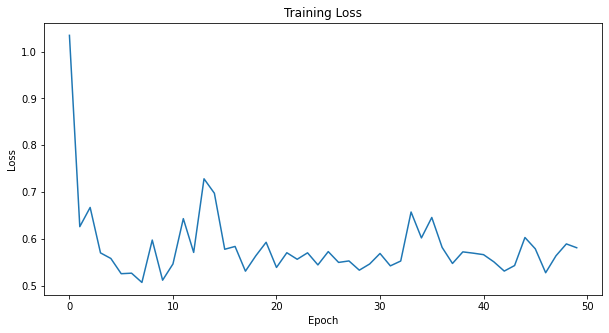

Test Loss: 0.2767


IndexError: ignored

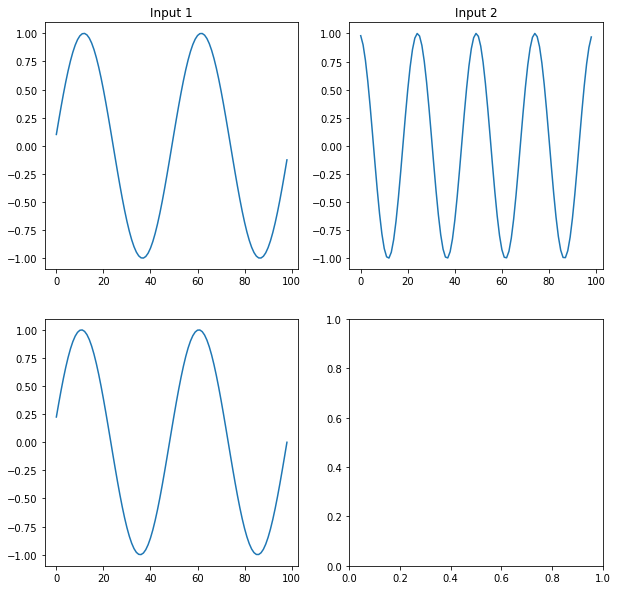

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CTRC model
class CTRC(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_reservoir, spectral_radius=0.9, connectivity=0.5, dt=0.01):
        super(CTRC, self).__init__()
        
        # Set the number of inputs and outputs
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # Set the time-step size
        self.dt = dt
        
        # Initialize the input-to-reservoir weight matrix
        self.input_weight = nn.Linear(n_inputs, n_reservoir, bias=False)
        torch.nn.init.normal_(self.input_weight.weight, mean=0, std=1)
        
        # Initialize the reservoir
        self.reservoir = nn.Linear(n_reservoir, n_reservoir, bias=False)
        torch.nn.init.normal_(self.reservoir.weight, mean=0, std=1)
        
        # Scale the reservoir connectivity
        self.reservoir.weight.data *= (torch.rand(n_reservoir, n_reservoir) < connectivity).float()
        
        # Set the spectral radius of the reservoir
        rho = torch.max(torch.abs(torch.linalg.eig(self.reservoir.weight)[0]))
        self.reservoir.weight.data *= spectral_radius / rho
        
        # Initialize the readout layer
        self.readout = nn.Linear(n_reservoir, n_outputs)
        
    def forward(self, input):
        # Initialize the reservoir state
        reservoir_state = torch.zeros(self.reservoir.weight.size(0)).to(device)
        
        # Iterate over the input sequence
        for i in range(input.size(0)):
            # Compute the reservoir state update
            input_proj = self.input_weight(input[i])
            reservoir_state = -self.dt * reservoir_state + torch.tanh(self.reservoir(reservoir_state) + input_proj)
        
        # Compute the readout layer output
        output = self.readout(reservoir_state)
        
        return output

# Define the training function
def train(model, dataloader, loss_fn, optimizer, num_epochs):
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            # Move the data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Update the running loss
            running_loss += loss.item()
            
        # Print the loss for this epoch
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(dataloader)))
        
        # Save the loss for plotting
        train_losses.append(running_loss/len(dataloader))
    
    return train_losses

# Define the main function
if __name__ == '__main__':
    # Set the random seed
    np.random.seed(0)
    torch.manual_seed(0)
    
    # Generate the input and output data
n_samples = 500
t = np.linspace(0, 10, n_samples)
x = np.sin(2 * np.pi * t)
y = np.cos(4 * np.pi * t)

# Reshape the input and output data
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Combine the input and output data
data = np.concatenate((x, y), axis=1)

# Split the data into training and testing sets
train_size = int(0.8 * n_samples)
train_data = data[:train_size, :]
test_data = data[train_size:, :]

# Create the training and testing datasets
train_dataset = TensorDataset(torch.Tensor(train_data[:-1, :]), torch.Tensor(train_data[1:, :]))
test_dataset = TensorDataset(torch.Tensor(test_data[:-1, :]), torch.Tensor(test_data[1:, :]))

# Define the model hyperparameters
n_inputs = 2
n_outputs = 2
n_reservoir = 100
spectral_radius = 0.9
connectivity = 0.5
dt = 0.01

# Create the CTRC model
model = CTRC(n_inputs, n_outputs, n_reservoir, spectral_radius, connectivity, dt).to(device)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create the training and testing data loaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Train the model
train_losses = train(model, train_dataloader, loss_fn, optimizer, num_epochs=50)

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test the model
test_loss = 0.0
test_outputs = []
for inputs, labels in test_dataloader:
    # Move the data to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    test_outputs.append(outputs.detach().cpu().numpy())
    
    # Compute the loss
    test_loss += loss_fn(outputs, labels).item()

# Print the test loss
print('Test Loss: %.4f' % (test_loss/len(test_dataloader)))

# Plot the test data and predictions
test_inputs = test_data[:-1, :]
test_labels = test_data[1:, :]
test_outputs = np.concatenate(test_outputs, axis=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].plot(test_inputs[:, 0])
ax[0, 0].set_title('Input 1')

ax[0, 1].plot(test_inputs[:, 1])
ax[0, 1].set_title('Input 2')

ax[1, 0].plot(test_labels[:, 0], label='True')
ax[1, 0].plot(test_outputs[:, 0], label='Predicted')
ax[1, 0].legend()
ax[1, 1].plot(test_labels[:, 1], label='True')
ax[1, 1].plot(test_outputs[:, 1], label='Predicted')
ax[1, 1].legend()
ax[1, 1].set_title('Output 2')

plt.tight_layout()
plt.show()




Epoch [1/50], Loss: 0.8514
Epoch [2/50], Loss: 0.6006
Epoch [3/50], Loss: 0.6019
Epoch [4/50], Loss: 0.5706
Epoch [5/50], Loss: 0.6060
Epoch [6/50], Loss: 0.6024
Epoch [7/50], Loss: 0.5861
Epoch [8/50], Loss: 0.6703
Epoch [9/50], Loss: 0.6525
Epoch [10/50], Loss: 0.5624
Epoch [11/50], Loss: 0.6295
Epoch [12/50], Loss: 0.7892
Epoch [13/50], Loss: 0.8272
Epoch [14/50], Loss: 0.7109
Epoch [15/50], Loss: 0.7169
Epoch [16/50], Loss: 0.8179
Epoch [17/50], Loss: 0.5537
Epoch [18/50], Loss: 0.5583
Epoch [19/50], Loss: 0.6154
Epoch [20/50], Loss: 0.6091
Epoch [21/50], Loss: 0.5561
Epoch [22/50], Loss: 0.6522
Epoch [23/50], Loss: 0.5510
Epoch [24/50], Loss: 0.6129
Epoch [25/50], Loss: 0.5649
Epoch [26/50], Loss: 0.6248
Epoch [27/50], Loss: 0.6603
Epoch [28/50], Loss: 0.6726
Epoch [29/50], Loss: 0.5494
Epoch [30/50], Loss: 0.5688
Epoch [31/50], Loss: 0.8227
Epoch [32/50], Loss: 0.6709
Epoch [33/50], Loss: 0.6345
Epoch [34/50], Loss: 0.6533
Epoch [35/50], Loss: 0.5340
Epoch [36/50], Loss: 0.5827
E

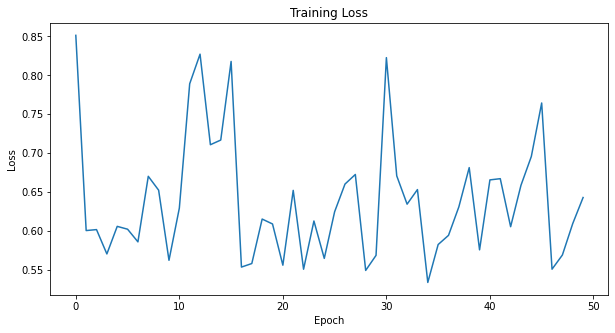

Test Loss: 0.2345


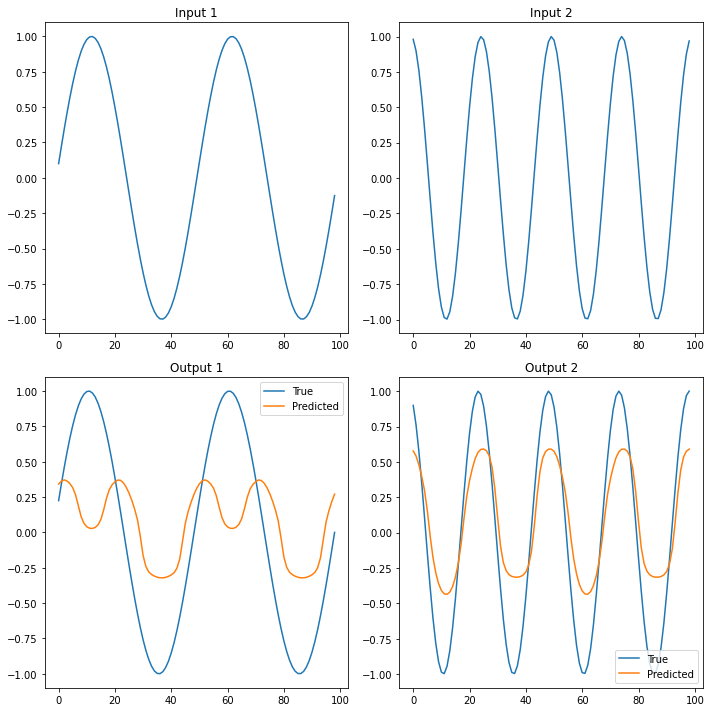

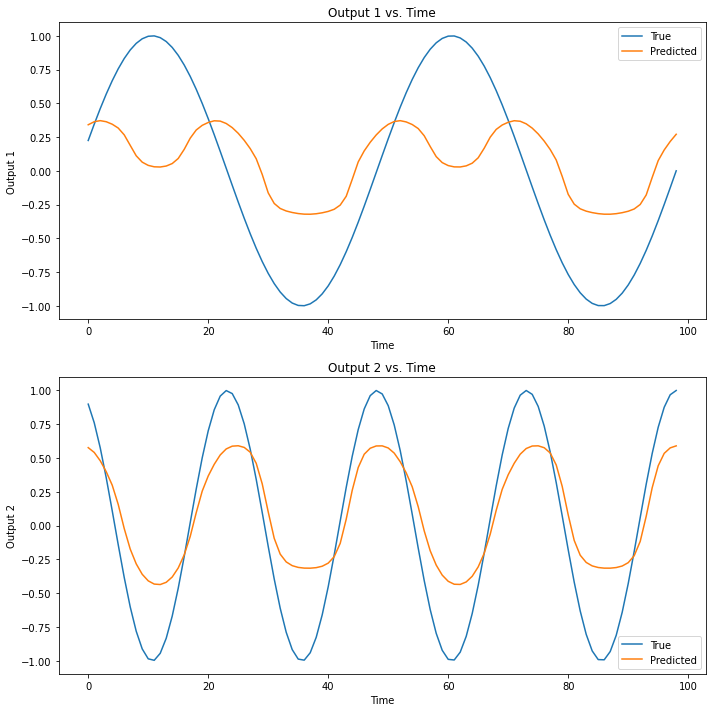

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CTRC model
class CTRC(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_reservoir, spectral_radius=0.9, connectivity=0.5, dt=0.01):
        super(CTRC, self).__init__()
        
        # Set the number of inputs and outputs
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # Set the time-step size
        self.dt = dt
        
        # Initialize the input-to-reservoir weight matrix
        self.input_weight = nn.Linear(n_inputs, n_reservoir, bias=False)
        torch.nn.init.normal_(self.input_weight.weight, mean=0, std=1)
        
        # Initialize the reservoir
        self.reservoir = nn.Linear(n_reservoir, n_reservoir, bias=False)
        torch.nn.init.normal_(self.reservoir.weight, mean=0, std=1)
        
        # Scale the reservoir connectivity
        self.reservoir.weight.data *= (torch.rand(n_reservoir, n_reservoir) < connectivity).float()
        
        # Set the spectral radius of the reservoir
        rho = torch.max(torch.abs(torch.linalg.eig(self.reservoir.weight)[0]))
        self.reservoir.weight.data *= spectral_radius / rho
        
        # Initialize the readout layer
        self.readout = nn.Linear(n_reservoir, n_outputs)
        
    def forward(self, input):
        # Initialize the reservoir state
        reservoir_state = torch.zeros(self.reservoir.weight.size(0)).to(device)
        
        # Iterate over the input sequence
        for i in range(input.size(0)):
            # Compute the reservoir state update
            input_proj = self.input_weight(input[i])
            reservoir_state = -self.dt * reservoir_state + torch.tanh(self.reservoir(reservoir_state) + input_proj)
        
        # Compute the readout layer output
        output = self.readout(reservoir_state)
        
        return output

# Define the training function
def train(model, dataloader, loss_fn, optimizer, num_epochs):
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            # Move the data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Update the running loss
            running_loss += loss.item()
            
        # Print the loss for this epoch
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(dataloader)))
        
        # Save the loss for plotting
        train_losses.append(running_loss/len(dataloader))
    
    return train_losses

# Define the main function
if __name__ == '__main__':
    # Generate the input and output data
    n_samples = 500
    t = np.linspace(0, 10, n_samples)
    x = np.sin(2 * np.pi * t)
    y = np.cos(4 * np.pi * t)
    
    # Reshape the input and output data
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    # Combine the input and output data
    data = np.concatenate((x, y), axis=1)
    
    # Split the data into training and testing sets
    train_size = int(0.8 * n_samples)
    train_data = data[:train_size, :]
    test_data = data[train_size:, :]
    
    # Create the training and testing datasets
    train_dataset = TensorDataset(torch.Tensor(train_data[:-1, :]), torch.Tensor(train_data[1:, :]))
    test_dataset = TensorDataset(torch.Tensor(test_data[:-1, :]), torch.Tensor(test_data[1:, :]))
    
    # Define the model hyperparameters
    n_inputs = 2
    n_outputs = 2
    n_reservoir = 100
    spectral_radius = 0.9
    connectivity = 0.5
    dt = 0.01
    
    # Create the CTRC model
    model = CTRC(n_inputs, n_outputs, n_reservoir, spectral_radius, connectivity, dt).to(device)
    
    # Define the loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Create the training and testing data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Train the model
    train_losses = train(model, train_dataloader, loss_fn, optimizer, num_epochs=50)
    
    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Test the model
    test_loss = 0.0
    test_outputs = np.zeros((n_outputs, test_data.shape[0]-1))
    for i, (inputs, labels) in enumerate(test_dataloader):
        # Move the data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        test_outputs[:, i] = outputs.squeeze().detach().cpu().numpy()
        
        # Compute the loss
        test_loss += loss_fn(outputs, labels).item()
    
    # Print the test loss
    print('Test Loss: %.4f' % (test_loss/len(test_dataloader)))
    
    # Plot the test data and predictions
    test_inputs = test_data[:-1, :]
    test_labels = test_data[1:, :]
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    ax[0, 0].plot(test_inputs[:, 0])
    ax[0, 0].set_title('Input 1')
    ax[0, 1].plot(test_inputs[:, 1])
ax[0, 1].set_title('Input 2')

ax[1, 0].plot(test_labels[:, 0], label='True')
ax[1, 0].plot(test_outputs[0, :], label='Predicted')
ax[1, 0].legend()
ax[1, 0].set_title('Output 1')

ax[1, 1].plot(test_labels[:, 1], label='True')
ax[1, 1].plot(test_outputs[1, :], label='Predicted')
ax[1, 1].legend()
ax[1, 1].set_title('Output 2')

plt.tight_layout()
plt.show()

# Plot the predicted and true outputs as a function of time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

t_test = np.arange(test_labels.shape[0])

ax[0].plot(t_test, test_labels[:, 0], label='True')
ax[0].plot(t_test, test_outputs[0, :], label='Predicted')
ax[0].legend()
ax[0].set_title('Output 1 vs. Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Output 1')

ax[1].plot(t_test, test_labels[:, 1], label='True')
ax[1].plot(t_test, test_outputs[1, :], label='Predicted')
ax[1].legend()
ax[1].set_title('Output 2 vs. Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Output 2')

plt.tight_layout()
plt.show()







INFO:root:Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
2023-02-21 22:59:42,015 INFO Using device: cpu
INFO:root:Epoch 1/10, Batch 1/40: Training Loss = 0.0019
2023-02-21 22:59:42,139 INFO Epoch 1/10, Batch 1/40: Training Loss = 

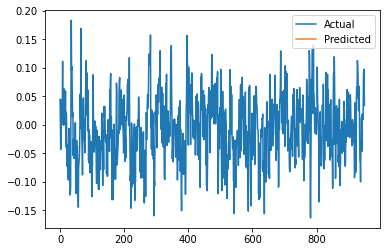

In [113]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Initialize the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter('%(asctime)s %(levelname)s %(message)s'))
logger.addHandler(handler)

class CTRC(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_reservoir, spectral_radius, connectivity, dt):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.dt = dt

        # Generate the reservoir
        self.reservoir = nn.Linear(n_reservoir, n_reservoir, bias=False)
        self.W = torch.rand(n_reservoir, n_reservoir) - 0.5
        self.W *= (torch.rand(n_reservoir, n_reservoir) < connectivity).float()
        rho = torch.max(torch.abs(torch.linalg.eig(self.reservoir.weight)[0]))
        self.W = self.W * (spectral_radius / rho)

        # Generate the input weights and output weights
        self.input_weights = nn.Linear(n_inputs, n_reservoir, bias=False)
        self.output_weights = nn.Linear(n_reservoir, n_outputs)

    def forward(self, input):
        # Initialize the reservoir state
        reservoir_state = torch.zeros(1, self.n_reservoir)

        # Iterate over the input sequence
        for i in range(input.size(0)):
            # Compute the reservoir state update
            reservoir_state = -self.dt * reservoir_state + torch.tanh(self.reservoir(reservoir_state) + self.input_weights(input[i]))

        # Compute the readout layer output
        output = self.output_weights(reservoir_state)
        return output.view(-1, self.n_outputs)  # match target tensor shape

def train(model, train_dataloader, loss_fn, optimizer, num_epochs=10):
    # Set the model to training mode
    model.train()

    # Train the model for num_epochs epochs
    for epoch in range(num_epochs):
        # Iterate over the training data
        for i, (inputs, targets) in enumerate(train_dataloader):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            targets = targets.view(-1, 1)  # Reshape targets to match output size
            loss = loss_fn(outputs, targets)

            # Backward pass
            loss.backward(retain_graph=True)  # Keep the computation graph for the backward pass
            optimizer.step()

            # Log the training loss for this epoch
            if i % 10 == 0:
                logger.info(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_dataloader)}: Training Loss = {loss.item():.4f}')

        # Log the training loss for the entire epoch
        logger.info(f'Epoch {epoch+1}/{num_epochs}: Training Loss = {loss.item():.4f}')

def get_sequences(data, seq_length):
    input_sequences = []
    output_sequences = []
    for i in range(len(data[0])-seq_length):
        input_seq = data[0][i:i+seq_length, :-1].numpy()
        output_seq = data[0][i+seq_length-1, -1]
        # Replace missing values with zeros
        input_seq = np.ma.masked_invalid(input_seq)
        input_seq = input_seq.filled(0)
        output_seq = 0 if np.isnan(output_seq) else output_seq
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)
    return np.array(input_sequences), np.array(output_sequences)

def test(model, test_data, seq_length):
    model.eval()
    with torch.no_grad():
        test_inputs, test_outputs = get_sequences(test_data, seq_length)
        test_inputs = torch.from_numpy(test_inputs).to(device)
        test_outputs = torch.from_numpy(test_outputs).to(device)
        test_outputs = test_outputs.unsqueeze(1)

        # Get predictions
        predicted_outputs = model(test_inputs)

        # Calculate mean squared error
        mse = np.mean(np.square(test_outputs.detach().cpu().numpy() - predicted_outputs.detach().cpu().numpy()))
        logger.info(f'Test MSE: {mse:.4f}')

        fig, ax = plt.subplots()
        ax.plot(test_data[seq_length:][0][:, 0].numpy(), label='Actual')
        ax.plot(predicted_outputs.cpu().numpy()[:, 0], label='Predicted')
        ax.legend()
        plt.show()



# Set the device to be used (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f'Using device: {device}')

# Generate the data
num_samples = 5000
n_inputs = 1
n_outputs = 1
data = np.zeros((num_samples, n_inputs + n_outputs))
for i in range(1, num_samples):
    data[i, 0] = 0.5 * data[i - 1, 0] + np.random.normal(0, 0.05)
    data[i, 1] = 0.4 * data[i - 1, 1] + 0.5 * data[i - 1, 0]

# Split the data into training and testing sets
train_data = data[:4000, :]
test_data = data[4000:, :]

# Create PyTorch DataLoader objects for the training and testing sets
batch_size = 100
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:, :n_inputs]).float(),
torch.from_numpy(train_data[:, n_inputs:]).float())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :n_inputs]).float(),
torch.from_numpy(test_data[:, n_inputs:]).float())

# Define the CTRC model
model = CTRC(n_inputs=n_inputs, n_outputs=n_outputs, n_reservoir=100, spectral_radius=0.99, connectivity=0.2, dt=0.1)
model.to(device)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 10
train(model, train_dataloader, loss_fn, optimizer, num_epochs=num_epochs)

# Test the model
seq_length = 50
test(model, test_dataset, seq_length)
